In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [ ]:
# Load dataset
file_path = "NIR_Data.xlsx"
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name='NIR Spectra_Predictors')

# Extract spectral data and target variable
X = df.drop(columns=["Sample ID", "Unnamed: 1", "Moisture"]).values
wl = np.array(df.columns[2:-1], dtype=float)  # Wavelengths
y = df["Moisture"].values

Dataset Statistical Summary:
       Unnamed: 1    11988.51     11980.8    11973.08    11965.37    11957.66  \
count  773.000000  773.000000  773.000000  773.000000  773.000000  773.000000   
mean   408.213454    0.555737    0.555510    0.555277    0.555048    0.554840   
std    248.050920    0.175660    0.175460    0.175265    0.175117    0.174975   
min      1.000000    0.267237    0.267553    0.267540    0.267290    0.267120   
25%    200.000000    0.420672    0.420877    0.421411    0.421568    0.421270   
50%    393.000000    0.499081    0.498969    0.498818    0.498389    0.497959   
75%    598.000000    0.687495    0.687133    0.687137    0.686687    0.685944   
max    949.000000    0.978465    0.977729    0.975623    0.973480    0.972385   

         11949.94    11942.23    11934.51     11926.8  ...    4057.888  \
count  773.000000  773.000000  773.000000  773.000000  ...  773.000000   
mean     0.554626    0.554355    0.554071    0.553910  ...    1.317717   
std      0.174754  

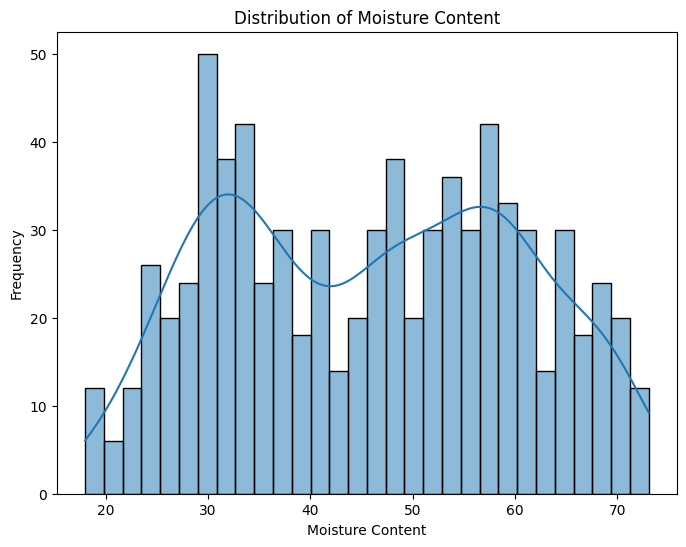

In [ ]:
# Display basic statistical summary of the dataset
print("Dataset Statistical Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values in Dataset:")
print(df.isnull().sum())

# Plot distribution of target variable (Moisture)
plt.figure(figsize=(8, 6))
sns.histplot(y, bins=30, kde=True)
plt.xlabel('Moisture Content')
plt.ylabel('Frequency')
plt.title('Distribution of Moisture Content')
plt.show()

In [ ]:
# Define Pre-processing functions
def msc(input_data):
    corrected_data = np.array(input_data, copy=True)
    ref = np.mean(corrected_data, axis=0)
    data_msc = np.zeros_like(corrected_data)
    for i in range(corrected_data.shape[0]):
        fit = np.polyfit(ref, corrected_data[i, :], 1, full=True)
        data_msc[i, :] = (corrected_data[i, :] - fit[0][1]) / fit[0][0]
    return data_msc

In [ ]:
def snv(input_data):
    return (input_data - np.mean(input_data, axis=1, keepdims=True)) / np.std(input_data, axis=1, keepdims=True)

In [ ]:
def savgol_smoothing(input_data, window_size=11, poly_order=2):
    return savgol_filter(input_data, window_length=window_size, polyorder=poly_order, axis=1)

In [ ]:
# Apply preprocessing techniques
X_raw = X
X_msc = msc(X)
X_snv = snv(X)
X_savgol = savgol_smoothing(X)

# Store preprocessed data in a dictionary
preprocessed_data = {
    "Raw": X_raw,
    "MSC": X_msc,
    "SNV": X_snv,
    "Savitzky-Golay": X_savgol
}


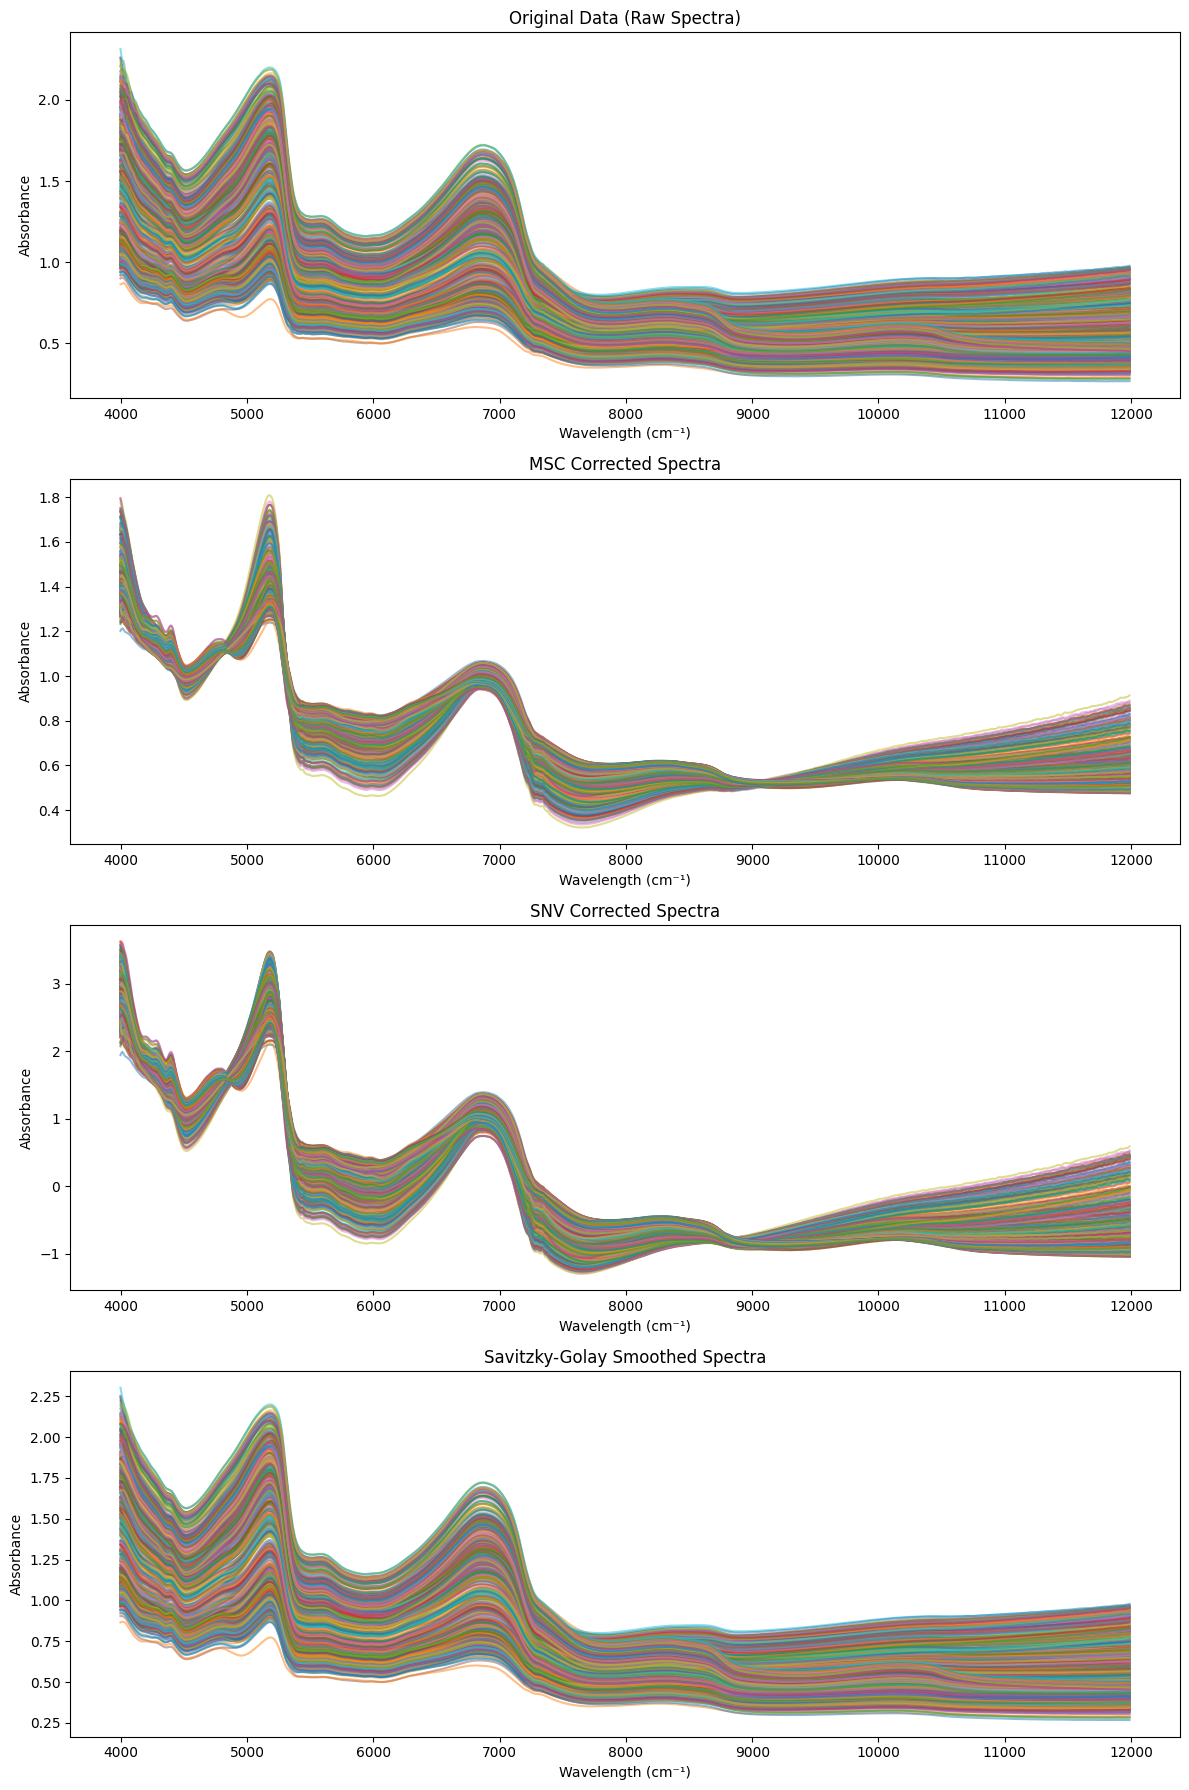

In [ ]:
# Visualization of Pre-Processing
plt.figure(figsize=(12, 18))

# Raw spectra
plt.subplot(4, 1, 1)
plt.plot(wl, X.T, alpha=0.5)
plt.xlabel("Wavelength (cm⁻¹)")
plt.ylabel("Absorbance")
plt.title("Original Data (Raw Spectra)")

# MSC Processed Spectra
plt.subplot(4, 1, 2)
plt.plot(wl, X_msc.T, alpha=0.5)
plt.xlabel("Wavelength (cm⁻¹)")
plt.ylabel("Absorbance")
plt.title("MSC Corrected Spectra")

# SNV Processed Spectra
plt.subplot(4, 1, 3)
plt.plot(wl, X_snv.T, alpha=0.5)
plt.xlabel("Wavelength (cm⁻¹)")
plt.ylabel("Absorbance")
plt.title("SNV Corrected Spectra")

# Savitzky-Golay Processed Spectra
plt.subplot(4, 1, 4)
plt.plot(wl, X_savgol.T, alpha=0.5)
plt.xlabel("Wavelength (cm⁻¹)")
plt.ylabel("Absorbance")
plt.title("Savitzky-Golay Smoothed Spectra")

plt.tight_layout()
plt.show()

In [ ]:
# Define models
models = {
    "PLS": PLSRegression(),
    "SVR": SVR(),
    "ANN": MLPRegressor(max_iter=1000)
}

In [ ]:
# Define RMSE scorer function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Store results
results = []

# Perform cross-validation for each pre-processing method and model
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for prep_name, X_prep in preprocessed_data.items():
    X_scaled = StandardScaler().fit_transform(X_prep)
    for model_name, model in models.items():
        if model_name == "PLS":
            best_n = 0
            best_score = -np.inf
            for n in range(2, 15):
                pls = PLSRegression(n_components=n)
                scores = cross_val_score(pls, X_scaled, y, cv=kf, scoring="r2")
                if scores.mean() > best_score:
                    best_score = scores.mean()
                    best_n = n
            model = PLSRegression(n_components=best_n)

        # Perform cross-validation
        scores_r2 = cross_val_score(model, X_scaled, y, cv=kf, scoring="r2")
        scores_rmse = cross_val_score(model, X_scaled, y, cv=kf, scoring=rmse_scorer)

        results.append({
            "Preprocessing": prep_name,
            "Model": model_name,
            "R2 Mean": scores_r2.mean(),
            "R2 Std": scores_r2.std(),
            "RMSECV Mean": -scores_rmse.mean(),
            "RMSECV Std": scores_rmse.std()
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)

     Preprocessing Model   R2 Mean    R2 Std  RMSECV Mean  RMSECV Std
0              Raw   PLS  0.962721  0.003944     2.775829    0.117229
1              Raw   SVR  0.878931  0.005929     5.009381    0.114422
2              Raw   ANN  0.346571  0.161513    10.503669    1.880623
3              MSC   PLS  0.971476  0.004084     2.424964    0.158260
4              MSC   SVR  0.917225  0.009929     4.136237    0.262086
5              MSC   ANN  0.687641  0.071130     8.156977    1.084455
6              SNV   PLS  0.971539  0.004717     2.419032    0.167844
7              SNV   SVR  0.921424  0.008128     4.031871    0.221164
8              SNV   ANN  0.942199  0.006600     3.081058    0.166026
9   Savitzky-Golay   PLS  0.962973  0.004097     2.765944    0.120729
10  Savitzky-Golay   SVR  0.878927  0.005935     5.009467    0.114465
11  Savitzky-Golay   ANN  0.401621  0.182879    11.645148    1.622690


<ipython-input-18-7b9d1fc9280b>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x="Preprocessing", y="R2 Mean", hue="Model", ci=None)


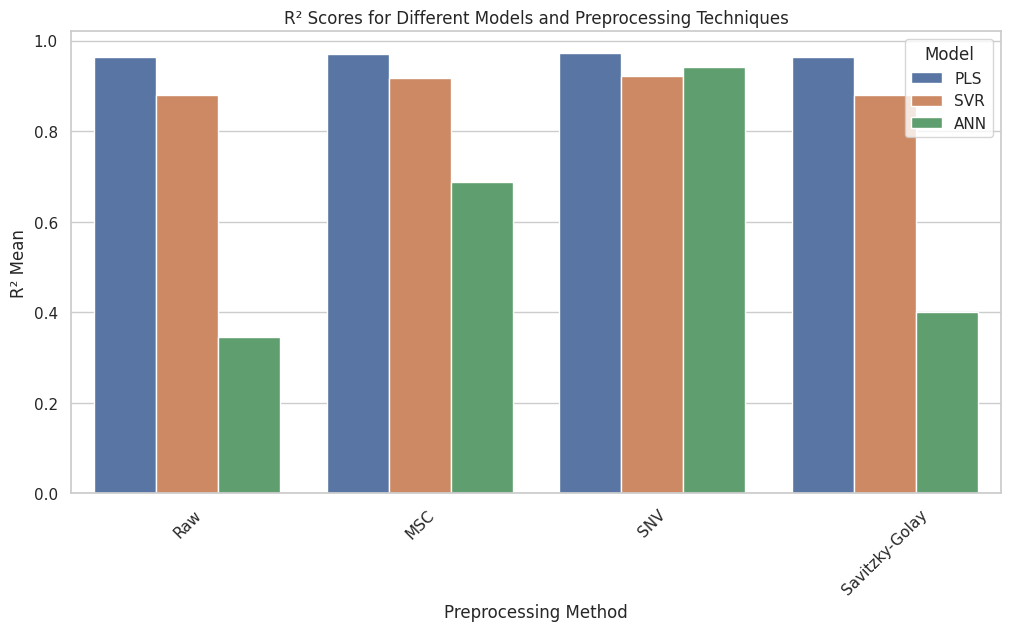

<ipython-input-18-7b9d1fc9280b>:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=results_df, x="Preprocessing", y="RMSECV Mean", hue="Model", ci=None)


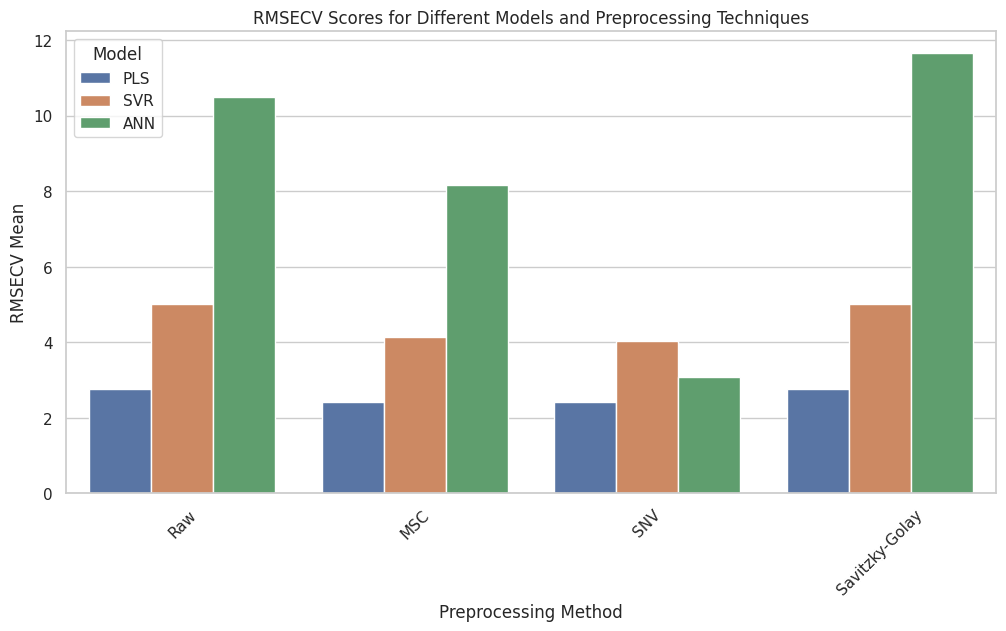

In [ ]:
# Set plot style
sns.set(style="whitegrid")

# Assuming results_df is already computed and available
# Plot R2 Scores
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Preprocessing", y="R2 Mean", hue="Model", ci=None)
plt.title("R² Scores for Different Models and Preprocessing Techniques")
plt.ylabel("R² Mean")
plt.xlabel("Preprocessing Method")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.show()

# Plot RMSE Scores
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Preprocessing", y="RMSECV Mean", hue="Model", ci=None)
plt.title("RMSECV Scores for Different Models and Preprocessing Techniques")
plt.ylabel("RMSECV Mean")
plt.xlabel("Preprocessing Method")
plt.legend(title="Model")
plt.xticks(rotation=45)
plt.show()